In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from desc.backend import jnp
from desc.grid import ConcentricGrid, LinearGrid
from desc.profiles import PowerSeriesProfile


np.set_printoptions(precision=3, floatmode="fixed")
jnp.set_printoptions(precision=3, floatmode="fixed")

DESC version 0.5.1+54.gdaa20db.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 8.16 GB available memory


## Visualizing different grids

In [3]:
def print_grid(grid, stop=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    """
    assert (
        len(grid.nodes) // grid.num_zeta
        == jnp.where(~jnp.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = len(grid.nodes)
    for i, e in enumerate(zip(grid.nodes, grid.spacing)):
        a, b = e
        print(a, b)
        if i > stop:
            break


rng = np.random.default_rng()
L = rng.integers(low=1, high=100)
M = rng.integers(low=1, high=100)
N = rng.integers(low=1, high=100)
NFP = rng.integers(low=1, high=100)
sym = True if rng.integers(2) > 0 else False
random_grid = ConcentricGrid(L=L, N=N, M=M, NFP=NFP, sym=sym)
print_grid(random_grid, stop=15)

10 48 72 54 False jacobi
6 311 145
nodes               spacing
[0.073 0.000 0.000] [5.742e-01 4.750e+00 3.033e-03]
[0.073 1.257 0.000] [5.742e-01 4.750e+00 3.033e-03]
[0.073 2.513 0.000] [5.742e-01 4.750e+00 3.033e-03]
[0.073 3.770 0.000] [5.742e-01 4.750e+00 3.033e-03]
[0.073 5.027 0.000] [5.742e-01 4.750e+00 3.033e-03]
[0.231 0.000 0.000] [0.696 0.990 0.003]
[0.231 0.262 0.000] [0.696 0.990 0.003]
[0.231 0.524 0.000] [0.696 0.990 0.003]
[0.231 0.785 0.000] [0.696 0.990 0.003]
[0.231 1.047 0.000] [0.696 0.990 0.003]
[0.231 1.309 0.000] [0.696 0.990 0.003]
[0.231 1.571 0.000] [0.696 0.990 0.003]
[0.231 1.833 0.000] [0.696 0.990 0.003]
[0.231 2.094 0.000] [0.696 0.990 0.003]
[0.231 2.356 0.000] [0.696 0.990 0.003]
[0.231 2.618 0.000] [0.696 0.990 0.003]
[0.231 2.880 0.000] [0.696 0.990 0.003]


## Bulk flux surface averaging test
The tests pass. timeit also shows the _surface_sums no loop algorithm is faster.

In [4]:
from desc.compute._core import surface_sums

function = np.random.random_sample(size=len(random_grid.nodes))

In [5]:
# %%timeit

iota_1 = np.empty(random_grid.num_rho)
# DESIRED ALGORITHM
# collect collocation node indices for each rho surface
surfaces = dict()
for index, rho in enumerate(random_grid.nodes[:, 0]):
    surfaces.setdefault(rho, list()).append(index)
# integration over non-contiguous elements
for i, surface in enumerate(surfaces.values()):
    iota_1[i] = function[surface].sum()

In [6]:
# %%timeit

# NO LOOP IMPLEMENTATION
bins = jnp.append(random_grid.nodes[random_grid.unique_rho_indices, 0], 1)
iota_2 = surface_sums(random_grid.nodes[:, 0], bins, function)
# bincount, bins = jnp.histogram(random_grid.nodes[:, 0], bins=bins)
# print(grid.nodes[random_grid.unique_rho_indices, 0])
# print(bincount)
# print(bins)

In [7]:
# must comment %%timeit to test assertion
print(iota_1)
print(iota_2)
assert jnp.allclose(iota_1, iota_2)

[ 364.899 1714.855 3170.326 4550.627 5996.460 7314.246]
[ 364.899 1714.855 3170.326 4550.627 5996.460 7314.246]


## Axisymmetric, vacuum, no current test
Want to test if the returned rotational transform profile is 0 when toroidal current input is 0.
This should be a good test because the bulk of the computation lies on enforcing the zero
toroidal current algorithm for the geometry of the device. And when a non-zero toroidal current is specified we just add it to the numerator because that is the delta poloidal flux term.

In [8]:
from desc.compute._core import compute_rotational_transform_v2


def get_concentric_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return ConcentricGrid(
        L=eq.L_grid,
        M=eq.M_grid,
        N=eq.N_grid,
        NFP=1,  # to avoid known grid bug
        sym=False,  # to avoid known grid bug
        node_pattern=eq.node_pattern,
    )


def get_transform(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        Concentric grid used by the given equilibrium.

    Returns
    -------
    Transform
         R_transform, Z_transform, L_transform of the given equilibrium.
    """
    from desc.compute import data_index
    from desc.transform import Transform

    r_derivs = data_index["sqrt(g)_rr"]["R_derivs"]
    l_derivs = jnp.vstack(
        (
            data_index["lambda_t"]["L_derivs"],
            data_index["lambda_rt"]["L_derivs"],
            data_index["lambda_rrt"]["L_derivs"],
            data_index["lambda_z"]["L_derivs"],
            data_index["lambda_rz"]["L_derivs"],
            data_index["lambda_rrz"]["L_derivs"],
        )
    )
    R_transform = Transform(grid, eq.R_basis, derivs=r_derivs, build=True)
    Z_transform = Transform(grid, eq.Z_basis, derivs=r_derivs, build=True)
    L_transform = Transform(grid, eq.L_basis, derivs=l_derivs, build=True)
    return R_transform, Z_transform, L_transform


def get_toroidal_current(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        The grid for the power series profile.

    Returns
    -------
    current : ndarray
        The toroidal current at each unique rho surface of the given equilibrium.
    """
    current = np.empty(grid.num_rho)
    for i, r in enumerate(grid.nodes[grid.unique_rho_indices, 0]):
        data = eq.compute("I", grid=LinearGrid(M=eq.M_grid, N=eq.N_grid, rho=r))
        current[i] = data["I"]
    assert jnp.isfinite(current).all(), "compute_quasisymmetry produces nan values"
    print(eq)
    print(current)
    return current
    # return PowerSeriesProfile.from_values(x=rho, y=current, grid=grid)


def get_iota_data(eq, I_l, power_series):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    I_l : ndarray
        Coefficients of the current profile. (params of power_series).
    power_series : PowerSeriesProfile
        The power series to compute the toroidal current.

    Returns
    -------
    data : dict
        The dictionary which contains at least iota, iota_r, iota_rr.
    """
    transform = get_transform(eq, power_series.grid)
    return compute_rotational_transform_v2(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        transform[0],
        transform[1],
        transform[2],
        eq.Psi,
        I_l=I_l,
        toroidal_current=power_series,
    )


def get_iota_data_v2(eq, power_series):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    power_series : PowerSeriesProfile
        Only used grid

    Returns
    -------
    data : dict
        The dictionary which contains at least iota, iota_r, iota_rr.
    """
    grid = get_concentric_grid(eq)
    current = get_toroidal_current(eq, grid)
    transform = get_transform(eq, grid)
    return compute_rotational_transform_v2(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        transform[0],
        transform[1],
        transform[2],
        eq.Psi,
        toroidal_current_unique_rho=current,
        toroidal_current=power_series,
    )

In [9]:
from desc.equilibrium import Equilibrium

torus = Equilibrium()
torus_I_l = jnp.zeros(2)
data = get_iota_data(
    torus,
    I_l=torus_I_l,
    power_series=PowerSeriesProfile(
        params=torus_I_l, modes=[0, 2], grid=get_concentric_grid(torus)
    ),
)
assert jnp.allclose(data["iota"], 0)

## Compare to VMEC test
Want to test if the rotational transform profile from new compute function matches the rotational transform profile computed by VMEC.

In [10]:
def plot(x, y, prepend_title):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 5 if len(x) > 64 else 10
    y = np.atleast_2d(y)
    fig, ax = plt.subplots(ncols=y.shape[0], figsize=(y.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size)
        ax[i].plot(x, y[i, :])
        ax[i].set(
            xlabel="rho",
            ylabel="iota" + append,
            yscale="symlog" if jnp.ptp(y[i, :]) > 1e3 else "linear",
            title=prepend_title + " iota" + append,
        )
        ax[i].grid()


def get_desc_plot(eq, params, modes):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    params : ndarray
        Coefficients of the current profile. (params of power_series).
    modes : ndarray
        Toroidal current power series profile modes.
        Should include only even modes to match VMEC AC input.

    Returns
    -------
    rho : ndarray
        unique rho values. x-axis of plot
    iotas : ndarray
        iota, iota_r, iota_rr at the unique rho values. y-axis of plot
    """
    grid = get_concentric_grid(eq)
    data = get_iota_data_v2(
        eq,
        # I_l=params,
        power_series=PowerSeriesProfile(params=params, modes=modes, grid=grid),
    )
    assert len(grid.nodes) == len(data["iota"])
    rho = grid.nodes[grid.unique_rho_indices, 0]
    iota = data["iota"][grid.unique_rho_indices]
    # iota_r = data["iota_r"][grid.unique_rho_indices]
    # iota_rr = data["iota_rr"][grid.unique_rho_indices]
    return rho, iota  # jnp.stack([iota, iota_r, iota_rr])


def get_vmec_plot(name):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.

    Returns
    -------
    rho : ndarray
        rho values. x-axis of plot.
    iota : ndarray
        iota. y-axis of plot.
    """
    from netCDF4 import Dataset

    f = Dataset("edu-vmec/wout_" + name + ".nc")
    iota = jnp.asarray(f.variables["iotaf"])
    rho = jnp.sqrt(jnp.linspace(0, 1, len(iota)))
    return rho, iota

In [11]:
# values are toroidal current profiles (AC input for VMEC)
stellarators = {
    "ATF": jnp.array([1, -1, 0]),
    "DSHAPE": jnp.array([2, -3, 0]),
    "SOLOVEV": jnp.array([4, -2, -1]),
    "HELIOTRON": jnp.array([2, -2, -1]),
    "AXISYM": jnp.array([1, -1, 0]),
}

## Note
VMEC says its HELIOTRON and AXISYM inputs may have convergence issues. Suggestion was to decrease DELT (step size). However, the error message remained.
DESC also says its HELIOTRON and AXISYM inputs exceed max function evaluations. This can be fixed by increasing `nfev` in the input files for HELIOTRON.
I did not change this to keep the input consistent with VMEC.

Equilibrium at 0x7f68740cc790 (L=24, M=12, N=4, NFP=12.0, sym=1, spectral_indexing=fringe)
[-2.718e-05 -3.002e-04 -1.293e-03 -3.674e-03 -8.227e-03 -1.578e-02
 -2.719e-02 -4.328e-02 -6.483e-02 -9.273e-02 -1.278e-01 -1.703e-01
 -2.187e-01 -2.698e-01 -3.185e-01 -3.585e-01 -3.835e-01]


AssertionError: compute_quasisymmetry produces nan values

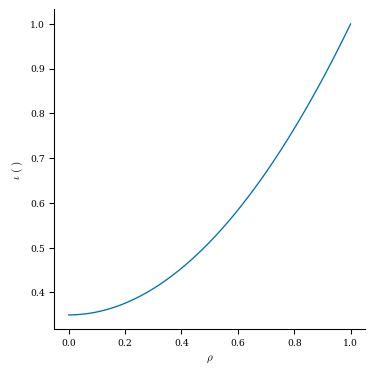

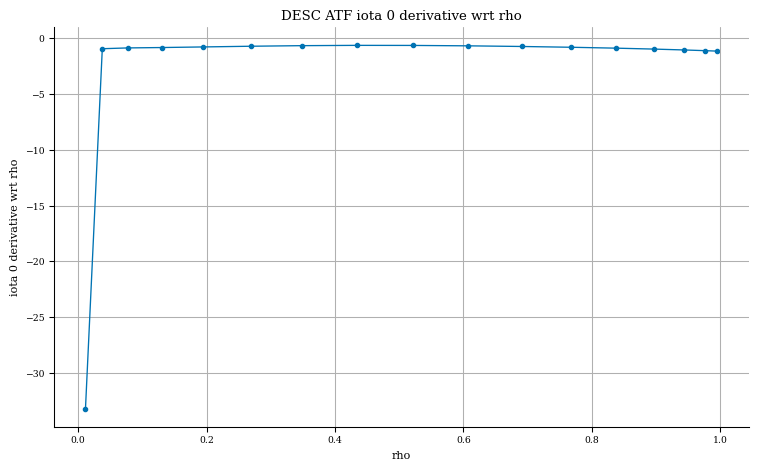

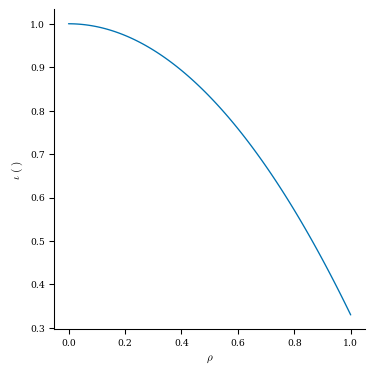

In [12]:
import desc.io
from desc.plotting import plot_1d

# plot DESC output
for name, params in stellarators.items():
    eq = desc.io.load("../examples/DESC/" + name + "_output.h5")[-1]
    plot_1d(eq, "iota")
    # modes are even to match VMEC psi modes
    rho, iota = get_desc_plot(eq, params, jnp.array([0, 2, 4]))
    plot(rho, iota, "DESC " + name)

In [ ]:
# plot VMEC output
for name in stellarators.keys():
    rho, iota = get_vmec_plot(name)
    plot(rho, iota, "VMEC " + name)